# Домашнее задание 3 [10 баллов] 
# До 16.05.18 23:59

Задание выполняется в группе (1-4 человека). В случае использования какого-либо строннего источника информации обязательно дайте на него ссылку (поскольку другие тоже могут на него наткнуться). Плагиат наказывается нулём баллов за задание и предвзятым отношением в будущем.

Не все части обязательны для выполнения, однако вы можете быть дополнительно оштрафованы за небрежное за выполнение одной или двух частей вместо четырех.

При возниконовении проблем с выполнением задания обращайтесь с вопросами к преподавателю. Поэтому настоятельно рекомендуется выполнять задание заранее, оставив запас времени на всевозможные технические проблемы. Если вы начали читать условие в последний вечер и не успели из-за проблем с установкой какой-либо библиотеки — это ваши проблемы.


Результат выполнения задания — это отчёт в формате html на основе Jupyter Notebook. Нормальный отчёт должен включать в себя:
* Краткую постановку задачи и формулировку задания
* Описание **минимума** необходимой теории и/или описание используемых инструментов - не стоит переписывать лекции или Википедию
* Подробный пошаговый рассказ о проделанной работе
* Аккуратно оформленные результаты
* **Внятные выводы** – не стоит относится к домашнему заданию как к последовательности сугубо технических шагов, а стоит относится скорее как к небольшому практическому исследованию, у которого есть своя цель и свое назначение.

Небрежное его оформление отчета существенно отразится на итоговой оценке. Весь код из отчёта должен быть воспроизводимым, если для этого нужны какие-то дополнительные действия, установленные модули и т.п. — всё это должно быть прописано в тексте в явном виде.

Сдача отчетов осуществляется через систему AnyTask.



# Классификация текстов с активным обучением


Зададимся простой задачей классификации текстов: например, классификацией отзывов на банки по тональности. Эта задача решается с достаточно высокими показателями качества с использованием стандартных алгоритмов классификации, например, сверточных нейронных сетей: корпус состоит из достаточного количества документов, чтобы сверточная сеть хорошо обучилась. Однако возникает естественный вопрос: действительно ли все документы нужны для того, чтобы достичь таких высоких показателей качества (или сопоставимых с ними). Парадигма активного обучения поможет вам ответить на этот вопрос.

## Часть 1. Предобработка данных [2 балла]

Коллекция отзывов хранится в файле banki_responses (https://www.dropbox.com/s/ol3ux3ibr6rd5ke/banki_responses.json.bz2?dl=0). Одна строчка в этом файле соответствует одному json-словарю. Из этого словаря вам понадобятся два значения по ключам text и rating -- текст отзыва и его оценка по шкале от 1 до 5.   

Считайте файл.

In [1]:
# Напишем функцию для разбиения предложения на слова (с удалением знаков пунктуации и
# приведением слов к нижнему регистру).
# Также напишем функцию для чтения коллекции отзывов из файла (игнорируя те, у которых не задана оценка).
# Каждый отзыв будем представлять словарем с полями:
# text -- текст отзыва,
# words -- слова отзыва,
# rating -- оценка в отзыве.

import json
import re


def split_into_words(sentence):
    regexp = "[^а-яА-ЯёЁa-zA-Z]"
    sentence = re.sub(regexp, " ", sentence)
    return sentence.lower().split()


def read_data(path='./data/banki_responses.json'):
    reviews = []
    with open(path, 'r') as fin:
        for line in fin:
            reviews.append(json.loads(line.strip()))
    return [{'text': review['text'],
             'words': split_into_words(review['text']),
             'rating': review['rating_grade']}
            for review in reviews
            if review['rating_grade'] is not None]

In [2]:
%%time

reviews = read_data()
print(f'Количество отзывов: {len(reviews)}.')

Количество отзывов: 136189.
Wall time: 52.7 s


Посчитайте, каких отзывов больше: положительных (с оценкой 5) или отрицательных (с оценкой 1)?

In [3]:
reviews_positive_count = sum(1 for review in reviews if review['rating'] == 5)
reviews_negative_count = sum(1 for review in reviews if review['rating'] == 1)
print(f'Количество положительных отзывов: {reviews_positive_count}.')
print(f'Количество отрицательных отзывов: {reviews_negative_count}.')
print(('Положительных' if reviews_negative_count < reviews_positive_count else 'Отрицательных')
      + ' отзывов больше.')

Количество положительных отзывов: 26715.
Количество отрицательных отзывов: 72307.
Отрицательных отзывов больше.


Проведите предварительную обработку данных: удалите слишком короткие и слишком длинные тексты (пороги на длину определите самостоятельно).

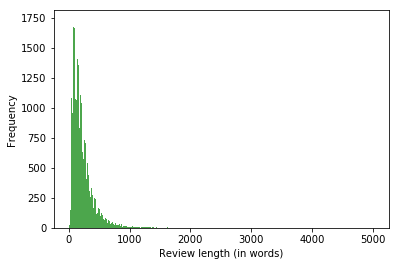

In [4]:
# Оценим распределение количества слов в отзывах, построив гистограмму.

from matplotlib import pyplot as plt


plt.hist([len(review['words']) for review in reviews], 2000, facecolor='green', alpha=0.7)
plt.xlabel('Review length (in words)')
plt.ylabel('Frequency')
plt.show()

In [5]:
# Оценим адекватность самых коротких отзывов,
# чтобы выявить нижнюю границу на количество слов в отзыве выборки.

for review in reviews:
    if len(review['words']) <= 5:
        print(f'{review["rating"]}: {review["text"]}')

1: Банк закрыт, на дверях замок.
5: Банк хороший, обслуживаением доволен!
5: Брал кредит все супер!
5: Очень хороший банк! Вежливые сотрудники!
1: Делают карту VISA почти 3 недели...
3: Охранники у банка слишком злые.


In [6]:
# Из гистограммы видно, что отзывы с количеством слов >= 1000 составляю малые долю всех отзывов.
# Поставим соответствующее ограничение сверху (1000) на количество слов в отзыве.

# Из предыдущего примера можно видеть, что самые короткие отзывы состоят из 4-5 слов,
# но при этом являются вполне адекватными, поэтому на текущем этапе причин для их удаления из выборки я не вижу.

# Однако, заглядывая вперед, можно увидеть, что сверточной сети придется работать с "изображениями" большого разрешения:
# (review_len, embedding_len), где
# review_len -- количество слов в отзыве, а
# embedding_len -- размер выходного вектора эмбеддинга.
# Посему хорошо бы уменьшить разрешение на входе сетки, а также заметить,
# что в ней будут использоваться pooling-слои, также понижающие размерность изображения.
# По этой причине исходная длина отзыва (в словах) должна быть не меньше чем downsample factor сети.
# Поставим соответствующее ограничение снизу (16) на количество слов в отзыве.

reviews = [review for review in reviews if 16 <= len(review['words']) < 1000]
print(f'Количество отзывов после фильтрации по количеству слов: {len(reviews)}.')

Количество отзывов после фильтрации по количеству слов: 134911.


Разбейте данные на обучающее ($train$) и тестовое ($test$) множество случайным образом в отношеннии 3:1 (или любом другом отношении, которое покажется вам разумным).
Задача классификации сформулирована так: по каждому отзыву определить его оценку (т.е. классификация на 5 классов). Признаками для классификации выступают слова.

In [7]:
# Разобьем коллекцию отзывов на обучающую и тестовую выборки.

import random

TRAIN_PERCENT = 0.75

reviews_indices_train = random.sample(list(range(len(reviews))),
                                      int(TRAIN_PERCENT * len(reviews)))
reviews_indices_test = list(set(range(len(reviews))) - set(reviews_indices_train))

reviews_train = [reviews[idx] for idx in reviews_indices_train]
reviews_test = [reviews[idx] for idx in reviews_indices_test]

print(f'В обучающей выборке {len(reviews_train)} отзывов.')
print(f'В тестовой выборке {len(reviews_test)} отзывов.')

В обучающей выборке 101183 отзывов.
В тестовой выборке 33728 отзывов.


In [8]:
%%time
# Загружаем fasttext модель, ограничиваясь первыми limit словами.

from gensim.models import KeyedVectors


fasttext_model = KeyedVectors.load_word2vec_format('../hw2_senna/wiki.ru.vec', limit=999999)

C:\Users\ASautin\AppData\Local\Continuum\Anaconda2\envs\con3.6\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Wall time: 4min 5s


In [9]:
# Напишем функцию, превращающую отзыв (словарь) в тензор, который можно будет подавать на вход сети.
# Для этого отображаем слова отзыва в соответствующие им индексы в языковой модели fasttext.

import numpy as np


def make_tensor_from_review(review, fasttext_model):
    words = review['words']
    tensor = np.zeros((len(words),))
    for idx, word in enumerate(words):
        word_in_vocab = fasttext_model.vocab.get(word, None)
        if word_in_vocab is not None:
            tensor[idx] = word_in_vocab.index
    return tensor

In [10]:
# Преобразуем отзывы обучающей и тестовой выборок в тензоры и отсортируем их по количеству слов.
# Сортировка полезна, чтобы избавиться от длинных паддингов при формировании и выравнивании батчей.
# Т.к. при обучении модели будет использоваться categorical_crossentropy loss,
# кодируем все метки классов с помощью one-hot-encoding.

from keras.utils import to_categorical


CLASS_COUNT = 5

tensors_train = [make_tensor_from_review(review, fasttext_model) for review in reviews_train]
tensors_test = [make_tensor_from_review(review, fasttext_model) for review in reviews_test]

indices_train = sorted(list(range(len(tensors_train))), key=lambda idx: tensors_train[idx].shape[0])
indices_test = sorted(list(range(len(tensors_test))), key=lambda idx: tensors_test[idx].shape[0])

tensors_train_sorted = [tensors_train[idx] for idx in indices_train]
tensors_test_sorted = [tensors_test[idx] for idx in indices_test]
ratings_train_sorted = [to_categorical(reviews_train[idx]['rating'] - 1, CLASS_COUNT)
                        for idx in indices_train]
ratings_test_sorted = [to_categorical(reviews_test[idx]['rating'] - 1, CLASS_COUNT)
                       for idx in indices_test]

Using TensorFlow backend.


In [29]:
# Объединяем тензоры и метки каждой из выборок в батчи и выравниваем тензоры внутри батча.
# Т.к. мы собираем батчи вручную, обучение нужно будет делать с помощью метода fit_generator,
# посему создаем бесконечные итераторы по батчам обеих выборок.

from keras.preprocessing.sequence import pad_sequences


def iterate_over_batches(batches_x, batches_y, randomize=False):
    indices = list(range(len(batches_x)))
    while True:
        if randomize:
            random.shuffle(indices)
        for idx in indices:
            yield batches_x[idx], batches_y[idx]

            
def make_batches(xs, ys, batch_size=BATCH_SIZE):
    batches_x = [xs[idx:idx + batch_size] for idx in range(0, len(xs), batch_size)]
    batches_x = [pad_sequences(batch, padding='post') for batch in batches_x]
    batches_y = [np.array(ys[idx:idx + batch_size]) for idx in range(0, len(ys), batch_size)]
    return batches_x, batches_y


BATCH_SIZE = 16

batches_train_x, batches_train_y = make_batches(tensors_train_sorted, ratings_train_sorted, BATCH_SIZE)
batches_test_x, batches_test_y = make_batches(tensors_test_sorted, ratings_test_sorted, BATCH_SIZE)

gen_train = iterate_over_batches(batches_train_x, batches_train_y, randomize=True)
gen_test = iterate_over_batches(batches_test_x, batches_test_y, randomize=False)

print(f'Количество батчей в обучающей выборке: {len(batches_train_x)}.')
print(f'Количество батчей в тестовой выборке: {len(batches_test_x)}.')

Количество батчей в обучающей выборке: 6324.
Количество батчей в тестовой выборке: 2108.


## Часть 2. Baseline [4 балла]

Получите baseline классификации: в идеале, используйте сверточную нейронную сеть (слой эмбеддингов + свертка + субдескритизация). Число и размерность фильтров определите самостоятельно, так же как и использование регуляризаторов (dropout / batch norm) и их параметров. Так же самостоятельно (но обосновано) решите, использовать ли вам предобученные эмбеддинги или нет и проводить ли вам лемматизацию или нет. 

Обучите сеть на обучающем множестве и протестируйте на тестовом. Зафиксируйте baseline.

Если совсем трудно или вычисления занимают слишком много времени, используйте любой другой известный и симпатичный вам алгоритм классификации. 

In [14]:
# Создадим модель сети с архитектурой DarkNet, которая хорошо себя показывает на
# задачах классификации и детекции при работе с изображениями.
# Компилируем модель классификатора и выводим ее краткое описание.

from keras.models import Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, MaxPool2D, Dropout
from keras.layers import Reshape, BatchNormalization, LeakyReLU, Activation
from keras.regularizers import l2


class DarknetBlock:
    def __init__(self, filters1, filters3, strides=(1, 1)):
        self._filters1 = filters1
        self._filters3 = filters3
        self._strides = strides

    def __call__(self, input_tensor, *args, **kwargs):
        x = input_tensor
        for filters, size, strides in [(self._filters3, (3, 3), self._strides),
                                       (self._filters1, (1, 1), (1, 1))]:
            x = Conv2D(filters, size, strides=strides, padding='same',
                       kernel_initializer='he_normal', kernel_regularizer=l2(1e-10))(x)
            x = LeakyReLU(alpha=0.05)(x)
        return x

    
def create_classifier_model(input_shape, class_count, fasttext_model, filter_counts=None):
    filter_counts = filter_counts or [16, 32, 64]
    downsample_factor = 1

    # Пользуемся функционалом gensim.KeyedVectors для создания слоя Embedding.
    # и инициализации его весами.
    embedding_layer = fasttext_model.get_keras_embedding()
    # Также отмечаем, что эти веса не надо менять при обучении сети.
    embedding_layer.trainable = False

    input_layer = Input(input_shape)
    embedding = embedding_layer(input_layer)
    # Добавляем ось каналов в тензор.
    reshaped = Reshape((1, -1, fasttext_model.vector_size))(embedding)
    x = reshaped
    # Понижаем размерность исходного изображения.
    x = Conv2D(10, (3, 3), strides=(2, 2), padding='same',
               kernel_initializer='he_normal', kernel_regularizer=l2(1e-10))(x)
    downsample_factor *= 2
    x = Conv2D(20, (3, 3), strides=(2, 2), padding='same',
               kernel_initializer='he_normal', kernel_regularizer=l2(1e-10))(x)
    downsample_factor *= 2
    # Сверточная сеть.
    for idx, filter_count in enumerate(filter_counts):
        x = DarknetBlock(filter_count, filter_count * 2)(x)
        x = DarknetBlock(filter_count, filter_count * 2)(x)
        if idx != len(filter_counts) - 1:
            x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
            downsample_factor *= 2
            x = BatchNormalization(axis=1)(x)
            x = Dropout(0.1)(x)
    # Классификация.
    x = Conv2D(class_count, (1, 1), padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax')(x)
    return Model(inputs=[input_layer], outputs=[output]), downsample_factor


classifier, downsample_factor = create_classifier_model((None,), CLASS_COUNT, fasttext_model)
print(f'Downsample factor: {downsample_factor}')
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.summary()

Downsample factor: 16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 300)         299999700 
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, None, 300)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, None, 150)     100       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, None, 75)      1820      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, None, 75)      5792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, None, 75)     

In [15]:
# Обучаем классификатор.
# Сохраняем лог обучения и веса модели.
# Выводим accuracy на обучающей и тестовой выборках.

import json
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=25, verbose=1),
    ModelCheckpoint('weights/baseline_best', monitor='val_loss', period=5, save_best_only=True),
]


def process_training_results(model, history, name='main'):
    with open(f'logs/{name}.json', 'w') as fout:
        json.dump(history.history, fout, sort_keys=True, indent=4)
    model.save_weights(f'weights/{name}')
    return {'acc': history.history['acc'][-1], 'val_acc': history.history['val_acc'][-1]}


history = classifier.fit_generator(gen_train, steps_per_epoch=len(batches_train_x) // 6,
                                   epochs=50, callbacks=callbacks,
                                   validation_data=gen_test, validation_steps=len(batches_test_x))
metrics_baseline = process_training_results(classifier, history, name='baseline')
print(metrics_baseline)

Epoch 1/50
1054/1054 [==============================] - 135s 129ms/step - loss: 1.1140 - acc: 0.6105 - val_loss: 1.0412 - val_acc: 0.6368
Epoch 2/50
1054/1054 [==============================] - 105s 99ms/step - loss: 0.9970 - acc: 0.6570 - val_loss: 1.3660 - val_acc: 0.6002
Epoch 3/50
1054/1054 [==============================] - 105s 100ms/step - loss: 0.9771 - acc: 0.6586 - val_loss: 1.0299 - val_acc: 0.6422
Epoch 4/50
1054/1054 [==============================] - 104s 99ms/step - loss: 0.9678 - acc: 0.6610 - val_loss: 1.0874 - val_acc: 0.6490
Epoch 5/50
1054/1054 [==============================] - 113s 107ms/step - loss: 0.9383 - acc: 0.6750 - val_loss: 0.9952 - val_acc: 0.6540
Epoch 6/50
1054/1054 [==============================] - 103s 97ms/step - loss: 0.9332 - acc: 0.6747 - val_loss: 0.9194 - val_acc: 0.6788
Epoch 7/50
1054/1054 [==============================] - 108s 103ms/step - loss: 0.9297 - acc: 0.6699 - val_loss: 0.9456 - val_acc: 0.6678
Epoch 8/50
1054/1054 [===============

In [47]:
# Освободим ресурсы GPU.
from keras import backend as K


K.clear_session()

## Часть 3. Baseline [4 балла] Активное обучение

Подход активного обучения основан на следующей идее: вместо всего обучающего множества мы используем его маленькие фрагменты, в которых модель неуверена для обучения. Таким образом, модель обучается исключительно по **трудным** объектам, число которых существенно меньше, чем общее число объектов.

Обучение модели начинается с обучения по $N$ случайно выбранным примерам, где $N$ – небольшое число (100, 200 и т.д.). Затем модель тестируется на $|train| - N$ объектах, после чего из  $|train| - N$ объектов выбираются снова $N$  объектов, в которых модель не уверена. Эти объекты используются для дообучения модели. Процесс выбора $N$ трудных объектов и дообучения на них повторяется некоторое количество раз (100, 200 и т.д. раз). На каждом шаге активного обучения модель можно протестировать на тестовом множестве, чтобы сравнить ее качества с baseline.

Как выбирать трудные объекты:
1. Выход нейронной сети - оценки 5 вероятностей принадлежности объекта одному из классов. Предсказанный класс – это тот класс, вероятность которого максимальна. Отсортируем объекты по убыванию вероятности предсказанного класса ($\min \max p_i$) и выберем $N$ первых объектов;
2. Используем энтропию: чем больше энтропия предсказания, тем ближе распределение вероятностей предсказания к равномерному распределению, тем труднее объект. 

In [48]:
# Создаем новый классификатор с той же архитектурой, компилируем его.

classifier, downsample_factor = create_classifier_model((None,), CLASS_COUNT, fasttext_model)
print(f'Downsample factor: {downsample_factor}')
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Downsample factor: 16


In [49]:
# Задаем гиперпараметры нашего эксперимента.

# Количество "трудных" объектов, на которых будет учиться сеть в рамках одной итерации.
CHUNK_SIZE = 256
# Количество итераций.
ITER_COUNT = 100
# Количество эпох в рамках одной итерации.
CHUNK_EPOCH_COUNT = 4
# Частота замера качества модели на тестовой выборке.
EVAL_FREQ = 10

In [50]:
# Реализуем идею активного обучения согласно описанию.

used_indices = set()
chunk_indices = set(random.sample(list(range(len(tensors_train_sorted))), CHUNK_SIZE))

for iter_idx in range(ITER_COUNT):
    print(f'Iter {iter_idx}')
    print('Training...', end=' ')
    # Разбиваем выбранные "трудные" объекты на батчи, создаем итератор по ним, обучаем сеть.
    chunk_tensors = [tensors_train_sorted[idx] for idx in chunk_indices]
    chunk_ratings = [ratings_train_sorted[idx] for idx in chunk_indices]
    chunk_batches_tensors, chunk_batches_ratings = make_batches(chunk_tensors, chunk_ratings, BATCH_SIZE)
    gen_batches = iterate_over_batches(chunk_batches_tensors, chunk_batches_ratings, randomize=True)
    classifier.fit_generator(gen_batches, steps_per_epoch=len(chunk_batches_tensors), epochs=CHUNK_EPOCH_COUNT, verbose=0)
    print('done')

    if iter_idx % EVAL_FREQ == EVAL_FREQ - 1:
        print('Evaluating on test...', end=' ')
        # Замеряем качество на тестовой выборке.
        metrics = classifier.evaluate_generator(gen_test, steps=len(batches_test_x))
        print('done')
        for metric_name, metric_value in zip(classifier.metrics_names, metrics):
            print(f'\t{metric_name}: {metric_value}')

    print('Updating indices...', end=' ')
    # Сгенерируем батчи из той части обучающей выборки, которая еще не участвовала в обучении.
    used_indices |= chunk_indices
    not_used_indices = [idx for idx in range(len(tensors_train_sorted)) if idx not in used_indices]
    not_used_tensors = [tensors_train_sorted[idx] for idx in not_used_indices]
    not_used_ratings = [ratings_train_sorted[idx] for idx in not_used_indices]
    not_used_batches_tensors, not_used_batches_ratings = make_batches(not_used_tensors, not_used_ratings, BATCH_SIZE)
    gen_batches = iterate_over_batches(not_used_batches_tensors, not_used_batches_ratings, randomize=False)
    print('done')
    
    # Предскажем классы на этой части выборки и выберем CHUNK_SIZE новых "трудных" объектов.
    print('Predicting on part of train...', end=' ')
    predictions = classifier.predict_generator(gen_batches, steps=len(not_used_batches_tensors))
    predictions_indices = sorted(list(range(len(predictions))), key=lambda idx: predictions[idx].max())
    chunk_indices = set(predictions_indices[:CHUNK_SIZE])
    print('done')
    print()

Iter 0
Training... done
Updating indices... done
Predicting on part of train... done

Iter 1
Training... done
Updating indices... done
Predicting on part of train... done

Iter 2
Training... done
Updating indices... done
Predicting on part of train... done

Iter 3
Training... done
Updating indices... done
Predicting on part of train... done

Iter 4
Training... done
Updating indices... done
Predicting on part of train... done

Iter 5
Training... done
Updating indices... done
Predicting on part of train... done

Iter 6
Training... done
Updating indices... done
Predicting on part of train... done

Iter 7
Training... done
Updating indices... done
Predicting on part of train... done

Iter 8
Training... done
Updating indices... done
Predicting on part of train... done

Iter 9
Training... done
Evaluating on test... done
	loss: 2.1596701613696294
	acc: 0.2078688330170778
Updating indices... done
Predicting on part of train... done

Iter 10
Training... done
Updating indices... done
Predicting o